In [ ]:
# pip install graphviz

   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   ---------------------------------- ----- 41.0/47.1 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 784.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [39]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [3]:
# Load the dataset
data = pd.read_excel('cleaned data.xlsx')

# Save as dataframe
data = pd.DataFrame(data)

In [40]:
# Split the data into features (X) and target (y)
X = data.drop(columns=['Take-up ind', 'Pno'], axis=1)
y = data['Take-up ind']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)



# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7, stratify=y)
X_train, X_test, y_train, y_test

(        Amount     Cover   SurrVal  Offer/APE  PercCover   CurrAge  \
 686   0.033584  0.057213  0.000000   0.167800   0.100601  0.504146   
 974   0.369195  0.232432  0.365517   0.104308   0.274951  0.537313   
 1040  0.004629  0.002286  0.000000   0.244898   0.417291  0.567164   
 155   0.008951  0.013353  0.000000   0.405896   0.141591  0.144279   
 375   0.019462  0.031213  0.000000   0.031746   0.114191  0.597015   
 ...        ...       ...       ...        ...        ...       ...   
 618   0.018295  0.009460  0.000000   0.374150   0.359056  0.714760   
 482   0.011068  0.051907  0.000000   0.086168   0.035054  0.527363   
 306   0.003834  0.010956  0.000000   0.043084   0.095816  0.459370   
 463   0.022952  0.071753  0.060504   0.070295   0.051044  0.250415   
 280   0.008841  0.016673  0.029127   0.040816   0.111309  0.759536   
 
       Fee_claimed  Smoker ind       APE  SurrVal/APE  ...  Mngt_act_ACD  \
 686           0.0         0.0  0.020724     0.000000  ...           0

In [41]:
#this code creates an instance of the RandomForestClassifier class and assigns it to the variable rf.
rf = RandomForestClassifier(n_estimators=100, random_state=42)
#fit the model to the training data X_train and y_train using the fit() method.
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [42]:
#Use the predict method of a RandomForestClassifier object (rf) to make predictions on a set of test data (X_test).
#The predicted values are then stored in the variable y_pred.
y_pred = rf.predict(X_test)

In [43]:
#Calculate the accuracy of predictions by comparing the predicted values (y_pred) to the actual values (y_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9269406392694064


Visualizing the results

In [8]:
pip install pydotplus

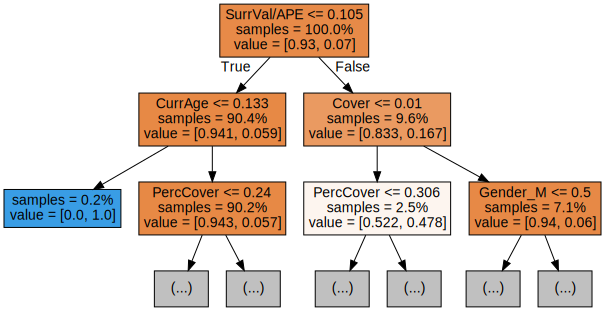

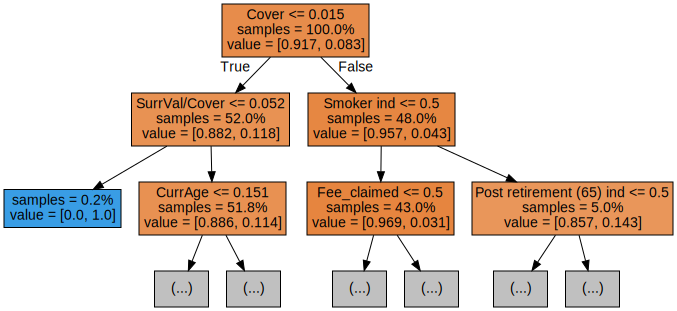

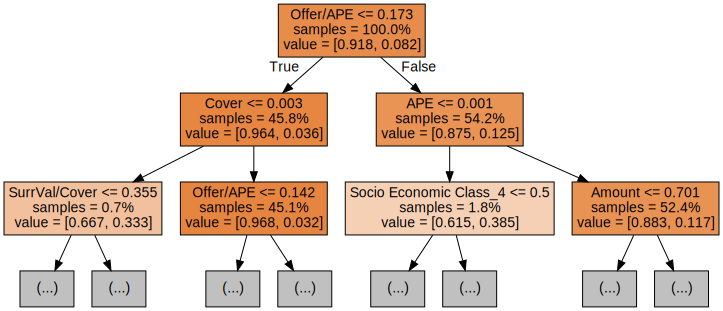

In [44]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Hyperparamter Tuning

In [45]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d9b4b801cc0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d9b501208b0>})

In [46]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)


Best hyperparameters: {'max_depth': 13, 'n_estimators': 196}


More Evaluation metrics


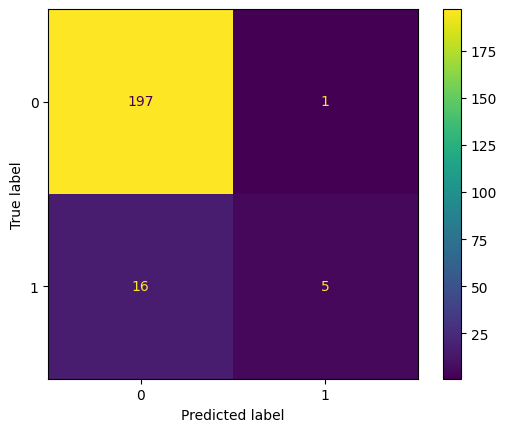

In [47]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [33]:
def calculate_metrics(y_true, y_pred, y_prob=None, metrics=['precision', 'recall', 'f1', 'accuracy', 'auc']):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    results = {}

    # Calculate precision
    if 'precision' in metrics:
        results['precision'] = round( TP / (TP + FP), 4) if (TP + FP) > 0 else 0

    # Calculate recall
    if 'recall' in metrics:
        results['recall'] = round( TP / (TP + FN), 4) if (TP + FN) > 0 else 0

    # Calculate F1 score
    if 'f1' in metrics:
        results['f1'] = round( 2 * (TP / (2 * TP + FP + FN)), 4) if (2 * TP + FP + FN) > 0 else 0

    # Calculate accuracy
    if 'accuracy' in metrics:
        results['accuracy'] = round( (TP + TN) / (TP + TN + FP + FN), 4)

    # Calculate AUC
    if 'auc' in metrics and y_prob is not None:
        # Note: AUC requires probabilities, not class labels.
        results['auc'] = round( roc_auc_score(y_true, y_prob), 4)

    return results

In [48]:
# Metrics
metrics = calculate_metrics(y_true=y_test, y_pred=y_pred, metrics=['precision', 'recall', 'f1', 'accuracy'])
print(metrics)
#{'precision': 0.375, 'recall': 0.1667, 'f1': 0.2308, 'accuracy': 0.9087}
# {'precision': 0.8571, 'recall': 0.2857, 'f1': 0.4286, 'accuracy': 0.9269}

{'precision': 0.8333, 'recall': 0.2381, 'f1': 0.3704, 'accuracy': 0.9224}


In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
# Define the kNN model
knn = KNeighborsClassifier(n_neighbors=3)

# Train the kNN model
knn.fit(X_test, y_pred)  # Ensure the model is fitted before making predictions

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9178082191780822
Precision: 1.0
Recall: 0.14285714285714285


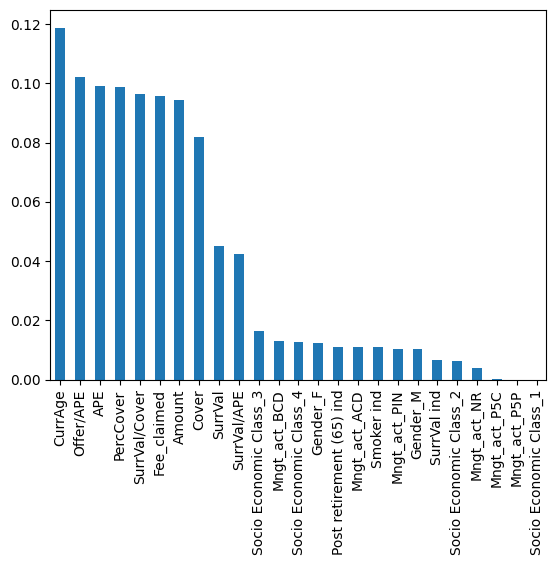

In [38]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot bar chart
feature_importances.plot.bar();